In [ ]:
# run_smemp_apf.ipynb
# Script to run Specmatch-Emp model on APF spectra and output results including derived stellar properties 
# and residual between target and best matching spectra.
# Last modified ?? by Anna Zuckerman
#
# NOTE: This script is modified from smemp_multifile.ipynb (itsefl modified from C.N's smemp.py). Modifications from smemp.py include added ability to process mulitple stellar
#      targets from a directory, new deblazing function, option to simplistically remove cosmic rays, and new output
#      files including output of residual. See project project write-up for details.  
#      Modifications are noted by the initials ADZ and the date.
# Input: path to a directory containing APF fits spectra files. If more than one file corresponds to a star, 
#      they must be grouped into a subdirectory.
# Output: Specmatch-emp derived Stellar properties in specmatch_results.csv, fits file for each star containing normalized,
#       deblazed target spectrum, residual between target sepctrum and linear combinatino of best matching spectra, and 
#       shifted wavelength scale. Also produces a log file. Please update file paths for these if needed before running.

In [92]:
# ADZ: allow importing .ipynb scripts 
!pip install import-ipynb

In [18]:
"""
@filename smemp_multifile.py

Derive properties of target stars using the Empirical SpecMatch algorithm and
write them to a csv file.
Display plots and figures of the process (optional).
"""
import import_ipynb #ADZ ADD 6/23/20
import pandas as pd #ADZ ADD 7/13/20
from astroquery.simbad import Simbad #ADZ ADD 8/6/20
import sys, os
from os import listdir
from os.path import isfile, join
import csv
from pylab import *
import pylab
import astropy.io.fits as pf
from astropy.io import fits
sys.path.append('specmatch-emp')
import specmatchemp.library
import specmatchemp.plots as smplot
from specmatchemp.spectrum import Spectrum
from specmatchemp.specmatch import SpecMatch
#from deblaze import afs_deblaze # ADZ comment out
from rescale import get_rescaled_wave_soln
from rescale import resample
from optparse import OptionParser
from bstar_deblaze import bstar_deblazed2 #ADZ ADD 7/17/20

In [19]:
def write_results(fd, my_spectrum, sm, write_new = False):
    """
    Write to a csv the derived properties of a target following
    the SpecMatch process
    Args:
        fd (File): object for the csv file to write to
        my_spectrum (spectrum.Spectrum): Target spectrum
        sm (specmatch.SpecMatch): Contains results of the algorithm
        write_new (Boolean): Whether to write to a new csv file
    """

    fieldnames = ['apf_name', 'Teff', 'u_Teff','radius','u_radius',
                  'logg','u_logg', 'feh','u_feh','mass','u_mass','age',
                  'u_age', 'best_mean_chi_squared']

    thewriter = csv.DictWriter(fd, fieldnames=fieldnames)

    if (write_new): thewriter.writeheader()

    thewriter.writerow({'apf_name' : my_spectrum.name,
                        'Teff' : '{0:.3f}'.format(sm.results['Teff']),
                        'u_Teff' : '{0:.3f}'.format(sm.results['u_Teff']),
                        'radius' : '{0:.3f}'.format(sm.results['radius']),
                        'u_radius' : '{0:.3f}'.format(sm.results['u_radius']),
                        'logg' : '{0:.3f}'.format(sm.results['logg']),
                        'u_logg' : '{0:.3f}'.format(sm.results['u_logg']),
                        'feh' : '{0:.3f}'.format(sm.results['feh']),
                        'u_feh' : '{0:.2f}'.format(sm.results['u_feh']),
                        'mass' : '{0:.3f}'.format(sm.results['mass']),
                        'u_mass' : '{0:.3f}'.format(sm.results['u_mass']),
                        'age' : '{0:.2f}'.format(sm.results['age']),
                        'u_age' : '{0:.2f}'.format(sm.results['u_age']),
                        'best_mean_chi_squared' :
                        '{0:.2f}'.format(best_mean_chi_squared)})


In [35]:
def run_specmatch(path_name, lib, display_plots): #ADZ: made this into a function 6/29/20

    print('EMPIRICAL SPECMATCH'), print()
    
    parser = OptionParser()
    parser.add_option("-f", "--file", action='store', type='string',
                      dest="pathname",
                      help="pass the path of the FITS file(s) as an argument")
    parser.add_option("-o", action='store', type='string',
                      dest="outputpath",
                      help="pass the path to a csv file to write to "
                           "as an argument")
    parser.add_option("-p", action="store_true", dest="plot",
                      help='plot')
    parser.add_option("--all", action="store_true", dest="all",
                      help='plots all wavelength regions')
    parser.add_option("--best", action="store_true", dest="best",
                      help='plots the reference, modified reference and residuals '
                           'for each of the best matches.')
    parser.add_option("--chi", action="store_true", dest="chi",
                      help='plot the chi-squared surface from the pairwise \
                      matching procedure')
    parser.add_option("--ref", action="store_true", dest="ref",
                      help='plot the locations of the best references used in the \
                      linear combination step')
    parser.add_option("--sr", action="store_true", dest="ref",
                      help='save the residuals ')

    (options, sys.argv) = parser.parse_args(sys.argv)

    # if no path given in command, prompt user for a path to a file or a directory
    # from which to acquire fits files
    # NOTE: program currently only known to work if all the files in the directory
    # are fits files and are intended targets

    #ADZ 6/29/20: removed this if statement; pathname is given when this function is called.
    #if (options.pathname == None):
    #path_name = input('Please enter the path to the FITS file(s) of a star: ') 
    #print()
    #else:
    #    path_name = options.pathname

    try:
        filenames = [f for f in listdir(path_name) if isfile(join(path_name, f))]
    except NotADirectoryError: # path to one file
        path_split = path_name.split('/')
        path_split[:-1] = ['/'.join(path_split[:-1])]
        filenames = []
        filename = path_split[-1]
        filenames.append(filename)
        path_name = path_split[0]

    
    # ADZ: remove test below 7/8/20 -> See function check2 in check_file_labeling.ipynb
    #                                (I tested that all files in each dir are for same star in that func.)
    
    # check to see if files are for the same star
    # NOTE: program currently does not work if the input directory contains fits
    # files for multiple stars
    #names = set() #ADZ comment out 
    #for filename in filenames:
    #    file = pf.open(path_name + '/' + filename,ignore_missing_end=True) #ADZ ADD ignore_missing_end=True
    #    header = file[0].header
    #    name = header['TOBJECT']
    #    names.add(name)
    #    if (len(names) > 1):
    #        print('Spectra Addition Error: ')
    #        print('This program sums the spectra for a star.')
    #        print('Please only provide the path to FITS files for the same star' +
    #              ' for a run of this program.')
     #       sys.exit()

    #display_plots = False
    if (options.plot or options.chi or options.best or options.ref):
        display_plots = True # bool var for whether or not to display plots

    # Prompt for regions to plot
    if ((display_plots) and (options.all == None)):
        print("0 : 5000 to 5100 Å")
        print("1 : 5100 to 5200 Å")
        print("2 : 5200 to 5300 Å")
        print("3 : 5300 to 5400 Å")
        print("4 : 5400 to 5500 Å")
        print("5 : 5500 to 5600 Å")
        print("6 : 5600 to 5700 Å")
        print("7 : 5700 to 5800 Å")
        print("8 : 5800 to 5900 Å")
        print("Please enter the corresponding numbers for " +
              "the wavelength regions to be plotted.")
        print("Separate the numbers with spaces.")
        print("Default option is only region 1. Simply press enter for " +
              "default option.")
        print("Enter \'all\' to plot all the regions.")
        
        while(True):
            inp = input('→ ')
            try:
                if (inp == ''): # Default - plot region 1
                    regions = [1]
                elif (inp == 'all'):
                    regions = (list(range(9)))
                else:
                    regions = [int(region) for region in sort(inp.split(" "))]
                    if (False in [(0 <= region <= 8) for region in regions]):
                        continue
            except ValueError: continue
            break

    else: # plot all
        regions = (list(range(9)))    
    
    # Read in data from wavelength solution
    wave_soln = (pf.open('apf_wav.fits'))[0].data

    # Sum all of the data files for a star
    data = np.zeros((79, 4608))

    ve = False
    counter  = 0
    for filename in filenames:
        file = pf.open(path_name + '/' + filename)
        data_part = file[0].data
        if counter == 0: #ADZ 7/26/20: get the header from the first file for this star, to use for the residual fits file 
            use_header = file[0].header
        counter += 1
        if (str(np.shape(data_part)) != '(79, 4608)'):
            print(str(np.shape(data_part)) + ' is an incompatible data shape.')
            print('Cannot perform shift-and-match process.')
            sys.exit()
        try:
            data += data_part
        except ValueError:
            ve = True

            
    if (ve):
        print("Value Error occurred during spectra summation.")

    header = file[0].header
    name = header['TOBJECT']
    print('Running SpecMatch-Emp on ' + name + ':')
    for filename in filenames:
        print(filename)

    ve = False
    #Deblaze the orders: 31 to 52 (range of focus in the SME library)
    for order_inc in range(22):
        try: #ADZ 7/17/20:  use B-star deblaze instead of afs_deblaze
           # data[30 + order_inc, :4607] = afs_deblaze(data[30 + order_inc],
           #                                           30 + order_inc)[0]
            data[30 + order_inc, :4600] = bstar_deblazed2(data,30 + order_inc)
        except ValueError: ve = True

    if (ve): print("Value Error occurred during blaze correction.")

    #ADZ: option to remove cosmic rays (simplistically) from normalized, deblazed spectrum 
    #     NOTE: set to FALSE when running this for results other than calibration
    remove_cosmic_rays = True
    def remove_cosmic_rays(spect): # must input a normalized, deblazed spectrum
        new_spect = spect 
        for i in range(len(spect)):
            old_value = spect[i]
            if old_value > 1.4:
                new_value = np.median(spect[i-3:i+3])
                new_spect[i] = new_value 
                print('replaced value ' + str(old_value) + ' with '+ str(new_value) +' at ' + str(i))
        return new_spect
    if remove_cosmic_rays == True:
        data = remove_cosmic_rays(data)   
    
    # Get a wavelength solution rescaled onto the scale of the library
    wave_soln_ref = get_rescaled_wave_soln()

    # Resample the spectrum onto the new wavelength scale
    data_new = resample(wave_soln_ref, wave_soln, data)

    # Create spectrum object
    my_spectrum = Spectrum(np.asarray(wave_soln_ref), np.asarray(data_new))
    my_spectrum.name = name

    #lib = specmatchemp.library.read_hdf() ADZ 8/10/20 moved this to outer loop so can remove stars from library
    
    sm = SpecMatch(my_spectrum, lib)

    # Perform shift
    sm.shift()

    # Perform match
    sm.match()

    # Perform lincomb
    sm.lincomb()

    # Chi squared values of the best match
    chi_squares = []

    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5000'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5100'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5200'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5300'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5400'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5500'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5600'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5700'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5800'])

    best_mean_chi_squared = np.mean(np.asarray(chi_squares))

    # Plot HR diagram
    fig1 = figure(figsize=(12, 10))
    sm.plot_references(verbose=True)
    # plot target onto HR diagram
    axes = fig1.axes
    axes[0].plot(sm.results['Teff'], sm.results['radius'], '*', ms=15, color='red', label='Target')
    axes[1].plot(sm.results['Teff'], sm.results['radius'], '*', ms=15, color='red')
    axes[2].plot(sm.results['feh'], sm.results['radius'], '*', ms=15, color='red')
    axes[3].plot(sm.results['feh'], sm.results['radius'], '*', ms=15, color='red')
    axes[0].legend(numpoints=1, fontsize='small', loc='best')
    plt.savefig()
    fig1.show()
    
    # Plot reference spectra and linear combinations
    fig2 = plt.figure(figsize=(12,6))
    sm_G.plot_lincomb()
    plt.savefig()
    fig2.show()
    
    # method of plotting currently not used
    if (display_plots):
        # Plot figures
        fignum = 0
        for r in regions:
            if (options.chi):
                fignum += 1
                plt.figure(fignum)
                fig3 = pylab.gcf()
                fig3.canvas.set_window_title('Chi-Squared Surface: Region ' + str(r))
                sm.plot_chi_squared_surface(region=r, num_best=None)
            if (options.best):
                fignum += 1
                plt.figure(fignum)
                fig1 = pylab.gcf()
                fig1.canvas.set_window_title('Best Match Spectra: Region ' + str(r))
                sm.plot_best_match_spectra(region=r, wavlim='all', num_best=None)
            if (options.ref):
                fignum += 1
                plt.figure(fignum)
                fig2 = pylab.gcf()
                fig2.canvas.set_window_title('References: Region ' + str(r))
                sm.plot_references(region=r, num_best=None, verbose=True)
            fignum += 1
            plt.figure(fignum)
            fig = pylab.gcf()
            fig.canvas.set_window_title('Linear Combination: Region ' + str(r))
            sm.plot_lincomb(region=r, wavlim='all')
            plt.show()

        # Plot shift
        fignum += 1
        plt.figure(fignum, figsize=(10,5))
        fig4 = pylab.gcf()
        fig4.canvas.set_window_title('Shift')
        sm.target_unshifted.plot(normalize=True, plt_kw={'color':'forestgreen'},
                                 text='Target (unshifted)')
        sm.target.plot(offset=0.5, plt_kw={'color':'royalblue'},
                       text='Target: ' + name + ' (shifted)')
        sm.shift_ref.plot(offset=1, plt_kw={'color':'firebrick'},
                          text='Reference: ' +sm.shift_ref.name)
        plt.xlim(5160,5190)
        plt.ylim(0,2.2)

        plt.show()

    # ADZ 7/10/20: 
    # return the (normalized, deblazed) target and the residual between the target spectrum and the linear combination of  
    # best matched spectra
    mt_lincomb = sm.lincomb_matches[0:9]
    residual_all_regions = np.zeros([0,0])
    target_all_regions = np.zeros([0,0])
    wl_all_regions = np.zeros([0,0])
    for n in range(9): 
        residual = mt_lincomb[n].target.s - mt_lincomb[n].modified.s # Changed this 7/27, was opposite order
        target = mt_lincomb[n].target.s
        residual_all_regions = np.append(residual_all_regions, residual)
        target_all_regions = np.append(target_all_regions, target)
        wl_all_regions = np.append(wl_all_regions, mt_lincomb[n].target.w) # Added 8/7, was calculating wl scale below
    
    #ADZ: create header-data-units to store output
    obs_name = filenames[0].split('.')[0] # letters corresponding to the set of observations used for this target
                                          # NOTE: assumes all spectra used are from single set of observations!
    use_header.set('RESID', 'YES','Residual output of Specmatch-emp (HDU 1)')
    use_header.set('SPECT', str(filenames).replace(']','').replace('[','').replace('\'','') ,'Spectra files used for target spectrum')
    use_header.set('NDR', 'YES','Normalized, deblazed, registered spctrm (HDU 2)')
           
    print(str(name) + ' COMPLETE') #ADZ 6/29/20: include name in statement
    return target_all_regions, residual_all_regions, wl_all_regions, use_header, obs_name, my_spectrum, sm, best_mean_chi_squared, options


Enter the path to the directory that contains the spectra:  ./APF_spectra/apf_spectra_highest_SNR/HIP98819_spectra


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


TypeError: savefig() missing 1 required positional argument: 'fname'

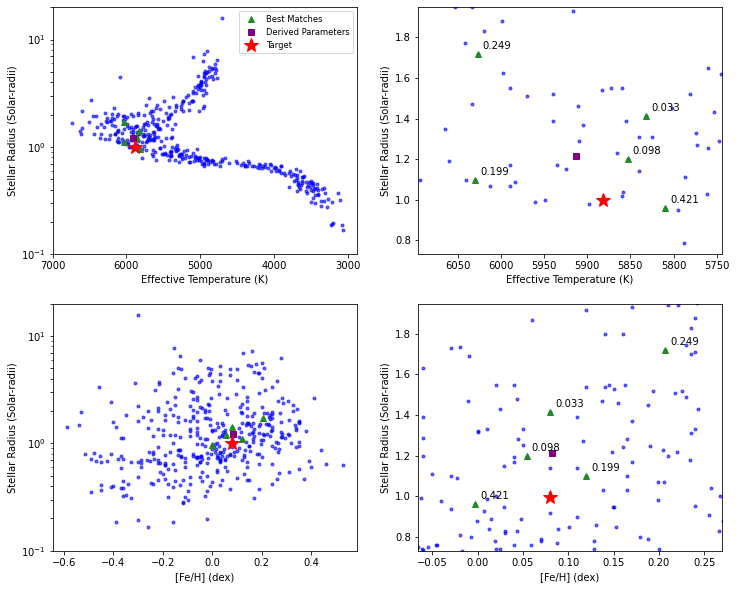

In [36]:
# -----------------------------------  ALL CODE BELOW THIS LINE ADDED BY ADZ -------------------------------------
# options
save_SM_object = 0 # to save specmathc objects
display_plots = 0 # to make plots
residuals_out_path =  'APF_spectra/NDRR/' # directory to save residuals to 
properties_out_path = 'SM_steller_properties/' # directory to save steller property results to

#  Get spectra filelist
path_to_dir = input('Enter the path to the directory that contains the spectra: ') 
filelist = os.listdir(path_to_dir)
# note if more than one spectra for a star, place in a subdirectory. 
try:
    filelist.remove('HIP5643_spectra') # remove problematic spectrum; produces an error but not due to labeling (GJ54.1)
    filelist.remove('.ipynb_checkpoints') # remove hidden file in this directory
except ValueError:
    pass
    
print('got here 1')     
    
# send output to 'specmatch_output.txt' (this is a log file for the current run)
# CAUTION! Deletes existing log files
if os.path.exists("specmatch_output.txt"):
    os.remove("specmatch_output.txt")
old_stdout = sys.stdout
sys.stdout = open('specmatch_output.txt', 'w')

# get wavelengths for residuals 
#wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
#region_lens = [5835, 5722, 5612, 5508, 5406, 5309, 5216, 5124, 5037]
#wl_all_regions = np.zeros([0,0])
#for n in range(9): 
#    wl = np.linspace(wl_regions[n][0], wl_regions[n][1], region_lens[n])
#    wl_all_regions = np.append(wl_all_regions, wl) 

#lib = specmatchemp.library.read_hdf() # Moved below so can remove stars and replace after running each star

# Run Specmatch-emp and save results, normalized, deblazed, registered target, and residuals
nameslist = []
pixel_shifts = []
for filename in filelist:   
    # get HIP star name from filename
    apf_name_conversion = pd.read_csv('apf_name_conversion_updated.csv')
    if filename.startswith('HIP'): # is a directory of spectra
        HIP_name = filename.split('_')[0] 
    elif filename.endswith('fits'): # is a single spectrum
        row = apf_name_conversion[apf_name_conversion['FILENAME'] == (filename.split('.')[0] + '.' + filename.split('.')[1])]
        HIP_name = row['HIP_NAME'].values.tolist()[0]
           
    # Remove star from library (for use in calibration run)
    lib = specmatchemp.library.read_hdf()
    lib_names = lib.library_params['cps_name'].to_list()
    result_table = Simbad.query_objectids(HIP_name)
    alt_names = result_table.to_pandas()
    alt_names = alt_names.iloc[:,0].str.decode('utf-8') # gets rid of weird formatting
    if HIP_name == 'HIP80824': # This is the only GJ star (that we are running) that isn't listed in library as GL
        lib_name = 'GJ628'
    else: # get the library name
        lib_name = [name.replace(' ','').replace('HD','').replace('GJ','GL') for name in alt_names.to_list() if name.replace(' ','').replace('HD','').replace('GJ','GL') in lib_names]
    idx = lib.get_index(lib_name) # get the idx in the library
    if idx == []:
        print('Could not find star ' + HIP_name + ' in catalog in order to remove.')
        break
    star = lib.pop(idx) # remove star from library
    print('For ' + HIP_name + ', removing corresponding star: ' + star[0]['cps_name'])
    
    # run Specmatch!
    star_target, star_residual, wl_scale, use_header, obs_name, my_spectrum, sm,best_mean_chi_squared, options= run_specmatch(str(path_to_dir) + '/' + filename, lib, display_plots) # Run Specmatch on each star  
    
    # save residual to fits file
    target_hdu = fits.PrimaryHDU(star_target, use_header)
    resid_hdu = fits.ImageHDU(star_residual)
    wl_hdu = fits.ImageHDU(wl_scale)
    hdu = fits.HDUList([target_hdu, resid_hdu, wl_hdu])
    #hdu.writeto(residuals_out_path + HIP_name + '_' + obs_name + '_NDRR.fits')  
    
    # Record results to csv file
    # if not provided an output file name, specmatch_results.csv is written to
    # (and created if not already)
    if (options.outputpath != None):
        if (not options.outputpath.endswith('.csv')):
            if (not options.outputpath.endswith('/')):
                options.outputpath += '/'
            options.outputpath += 'specmatch_results.csv'
        if isfile(options.outputpath):
            with open(options.outputpath,'a') as fd:
                write_results(fd, my_spectrum, sm)
        else:
            with open(options.outputpath, 'w', newline='') as fd:
                write_results(fd, my_spectrum, sm, write_new = True)
    else:
        if isfile(properties_out_path + 'specmatch_results.csv'):
            with open(properties_out_path + 'specmatch_results.csv','a') as fd: write_results(fd, my_spectrum, sm)
        else:
            with open(properties_out_path + 'specmatch_results.csv', 'w', newline='') as fd:
                write_results(fd, my_spectrum, sm, write_new = True)
    
    # find the (approximate) pixel shift used during shifting 
    # NOTE: this is currently not saved anywhere, and has not yet been shown to provide the correct shfit value! 
    pixel_shift = np.median(sm.shift_data['lag'])
    pixel_shifts = pixel_shifts + [pixel_shift]
    
    # Can save the entire SpecMatch object using: 
    if save_SM_object:
        save_sm_path = './Specmatch_objects/' + HIP_name + '.hdf'
        sm.to_hdf(save_sm_path)

sys.stdout = old_stdout


In [10]:
# Save pixel shifts, if desired
#HIP_names = pd.read_csv('Star_list.csv')['HIP_NAME'].to_list()
#pix_shift_array = np.array(pixel_shifts)
#df = pd.DataFrame(pix_shift_array, index = HIP_names, columns =['Pixel_shifts']) 
#df.to_csv('Pixel_shifts.csv')

In [ ]:
#./APF_spectra/apf_spectra_highest_SNR/HIP98819_spectra